### Syscoin Supply + Masternode Reward Simulations
* https://etherscan.io/chart/transactionfee

In [1]:
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin, minimize
import statsmodels.api as sm
from pymc3.gp.util import plot_gp_dist

import os
cwd =  os.getcwd()
cwd =  os.getcwd().replace("syscoin_research/notebooks","")
os.chdir(cwd)

In [2]:
# Jun 03 2019 (start)
# supply = 554103161

# June 28th, 2021
# supply 614730694

# Aug 23, 2021 
# supply 617746652

# July 12th, 2022 
# supply 650631036 + 100000000 - 13116676 = 737514361

### Simulate Prices

In [3]:
MASTERNODE_FEE = 100000
MASTERNODE_SUPPLY_SHARE = 0.34

def n_masternodes(supply_arr, share = MASTERNODE_SUPPLY_SHARE):
    return share*supply_arr/MASTERNODE_FEE

def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c

def gen_drift(N):    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    return mod.simulate([0.5, -5/3, 5/6, 4**2], N)

def scale_array(dat, out_range=(-1, 1)):
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))

def gen_prices(N, lwr_price, upr_price):
    
    x = range(1,N+1)
    y_trend = np.array([func_exp(e, 1, 0.002,0) for e in x])
    y_trend = scale_array(y_trend, (lwr_price, upr_price))
    drift = scale_array(np.abs(gen_drift(N)), (0, 1))
    sim = lwr_price + y_trend*drift
    
    return sim

In [4]:
utxo_supply = 650631037.54678924
nevm_supply = 100000000 - 13116676.320312181517900351
tot_supply = utxo_supply + nevm_supply # July 12th, 2022
tot_supply

737514361.2264771

### Ethereum Transaction Fees
* https://etherscan.io/chart/transactionfee
* last download: July 12th, 2022 

In [5]:
tx_fee = pd.read_csv('../resources/ETHTransactionFee.csv')
tx_fee.columns = ['date', 'timestamp','tx_fee']
tx_fee = tx_fee.assign(tx_fee = [float(tx)/1e18 for tx in tx_fee['tx_fee'].values])
date_split = [t.rstrip().split('/') for t in tx_fee['date'].values]
date_times = [datetime.date(int(t[2]), int(t[0]), int(t[1])) for t in date_split]
tx_fee = tx_fee.assign(date_time = date_times)

In [6]:
INITIAL_SYS_SUPPLY = 614730694.63 # June 28th, 2021
MAX_COINS = 888000000
DAYS_IN_YEAR = 365
ANNUAL_INFLATION = 0.05
DAILY_PERCENTAGE_GRWTH = (1+ANNUAL_INFLATION)**(1/DAYS_IN_YEAR)
LAST_DATE = '2021-06-28 00:00:00'
START_DATE = '2015-11-07 00:00:00'

In [7]:
def supplyNYears(A,t):
    return A*(1.05)**t

def supplyNDays(A,t):
    daysInYr = 366 if isLeapYear(getDate(t, strt_date = LAST_DATE).year) else 365
    return A*(1.05)**(t/365)

In [8]:
def isLeapYear(yr):
    return bool((yr-2000) % 4 == 0) 

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=t) 

In [9]:
N = 365
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
STRT_YR = 2019
DEFLATION = 0.05
INITIAL_BLK_REWARD = 151767*12/(365*24*60) + 7.81 + 23.45
NUM_DAILY_BLOCKS = 24*60

def gen_block_rewards(strt_date = STRT_DATE,
                      strt_supply = STRT_SUPPLY,
                      ini_blk_reward = INITIAL_BLK_REWARD,
                      n = N,
                      deflation = DEFLATION,
                      num_daily_blocks = NUM_DAILY_BLOCKS,
                      nevm_rewards = None,
                      pow_rewards = None):
    
    STRT_YR = datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S").year
    blk_rewards = [ini_blk_reward]
    dates = np.array([getDate(t, strt_date = strt_date) for t in range(0,n)])
    da = np.array([dates.flatten()[t].day for t in range(0,n)])
    mo = np.array([dates.flatten()[t].month for t in range(0,n)])
    yr = np.array([dates.flatten()[t].year for t in range(0,n)])

    rewards = np.repeat(0.0,n)
    rewards[0] = blk_rewards[0]

    for k in range(1, n):
        diff_yr = yr[k] - yr[k-1]
        rewards[k-1] = blk_rewards[len(blk_rewards)-1]
        
        if diff_yr == 1:
            blk_reward = blk_rewards[len(blk_rewards)-1]
            blk_rewards.append(blk_reward - deflation*blk_reward)

    rewards[n-1] = rewards[n-2]  
    
    daily_rewards = rewards*num_daily_blocks       
            
    df = pd.DataFrame({'dates':dates.flatten(),
                       'yr':yr.flatten(),
                       'mo':mo.flatten(),
                       'da':da.flatten(),
                       'blk_reward':rewards,
                       'daily_rewards':daily_rewards,
                       'supply':strt_supply+np.cumsum(daily_rewards)})
    
    if (nevm_rewards != None): 
        df.insert(loc=5, column='nevm_rewards', value=nevm_rewards)

    if (pow_rewards != None): 
        df.insert(loc=6, column='pow_rewards', value=pow_rewards)  
        
    if (nevm_rewards != None) & (pow_rewards != None):
        rewards = rewards + np.repeat(nevm_rewards,n)
        daily_rewards = rewards*num_daily_blocks 
        df = df.assign(daily_rewards=daily_rewards)
          
    return df

### Supply Pre-NEVM

In [10]:
INDEX = 812
SUPPLY_AT_INDEX = 617746652 # Aug 23, 2021 
N_DAYS_TO_NEVM = 917

def objective_function(alpha):
    
    pow_df = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = alpha*38.5,
                           n = N_DAYS_TO_NEVM)
                  
    return abs(SUPPLY_AT_INDEX - pow_df['supply'].iloc[INDEX])

#### Estimate senority scaling factor

In [11]:
ALPHA_INIT = 1.4872300387520823
result = minimize(objective_function, ALPHA_INIT, method='SLSQP', options={'maxiter': 1000})
senority_scaling_factor = result.x[0]
senority_scaling_factor

1.4874179911283243

In [12]:
STRT_DATE = '2019-06-03 00:00:00'
STRT_SUPPLY = 554103161
NUM_DAILY_BLOCKS = 24*60
INITIAL_BLK_REWARD = senority_scaling_factor*38.5

pre_nevm = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           n = N_DAYS_TO_NEVM)

In [13]:
pre_nevm.tail(3)

,dates,yr,mo,da,blk_reward,daily_rewards,supply
914,2021-12-03,2021,12,3,51.682197,74422.364219,6.253377e+08
915,2021-12-04,2021,12,4,51.682197,74422.364219,6.254122e+08
916,2021-12-05,2021,12,5,51.682197,74422.364219,6.254866e+08


### Supply Post-NEVM

In [14]:
2.5*(151767*12/(365*24*60) + 7.81 + 23.45)

86.81249999999999

In [75]:
24*60*60

86400

In [74]:
24*60*60 / 150

576.0

In [15]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 23.45)

nevm_lwr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 5.27)

In [16]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*pre_nevm['blk_reward'].iloc[-1]

nevm_med = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [17]:
N = 12*365+3
STRT_DATE = '2021-12-06 00:00:00'
STRT_SUPPLY = pre_nevm['supply'].iloc[-1]
NUM_DAILY_BLOCKS = 24*60*60 / 150
INITIAL_BLK_REWARD = 2.5*(151767*12/(365*24*60) + 7.81 + 46.9)

nevm_upr = gen_block_rewards(strt_date = STRT_DATE, 
                           strt_supply = STRT_SUPPLY, 
                           ini_blk_reward = INITIAL_BLK_REWARD,
                           num_daily_blocks = NUM_DAILY_BLOCKS,
                           n = N,
                           nevm_rewards = 10.55,
                           pow_rewards = 10.55)

In [18]:
nevm_df = nevm_lwr.iloc[:, [0,1,2,3]]
nevm_df.insert(loc=4, column='blk_reward_lwr', value=nevm_lwr['blk_reward'].values)
nevm_df.insert(loc=5, column='nevm_rewards_lwr', value=nevm_lwr['nevm_rewards'].values)
nevm_df.insert(loc=6, column='pow_rewards_lwr', value=nevm_lwr['pow_rewards'].values)
nevm_df.insert(loc=7, column='daily_rewards_lwr', value=nevm_lwr['daily_rewards'].values)
nevm_df.insert(loc=8, column='supply_lwr', value=nevm_lwr['supply'].values)

nevm_df.insert(loc=9, column='blk_reward_upr', value=nevm_upr['blk_reward'].values)
nevm_df.insert(loc=10, column='nevm_rewards_upr', value=nevm_upr['nevm_rewards'].values)
nevm_df.insert(loc=11, column='pow_rewards_upr', value=nevm_upr['pow_rewards'].values)
nevm_df.insert(loc=12, column='daily_rewards_upr', value=nevm_upr['daily_rewards'].values)
nevm_df.insert(loc=13, column='supply_upr', value=nevm_upr['supply'].values)

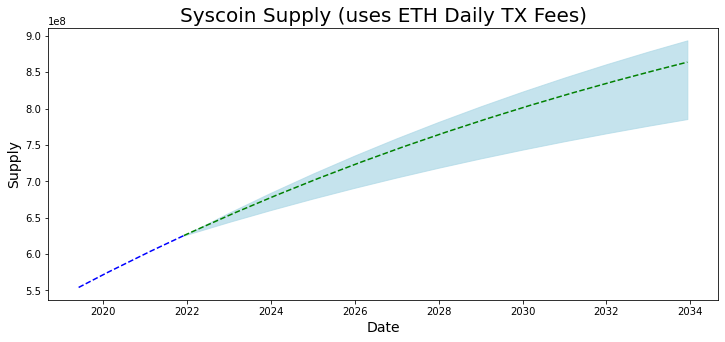

In [19]:
fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_df['dates'].values, nevm_df['supply_lwr'].values, nevm_df['supply_upr'].values, alpha=0.7, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
plt.ylabel("Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)
fig.savefig('../img/syscoin_daily_supply.png')


In [20]:
nevm_df

,dates,yr,mo,da,blk_reward_lwr,nevm_rewards_lwr,pow_rewards_lwr,daily_rewards_lwr,supply_lwr,blk_reward_upr,nevm_rewards_upr,pow_rewards_upr,daily_rewards_upr,supply_upr
0,2021-12-06,2021,12,6,86.81250,10.55,5.27,56080.800000,6.255366e+08,145.43750,10.55,10.55,89848.800000,6.255703e+08
1,2021-12-07,2021,12,7,86.81250,10.55,5.27,56080.800000,6.255866e+08,145.43750,10.55,10.55,89848.800000,6.256541e+08
2,2021-12-08,2021,12,8,86.81250,10.55,5.27,56080.800000,6.256366e+08,145.43750,10.55,10.55,89848.800000,6.257379e+08
3,2021-12-09,2021,12,9,86.81250,10.55,5.27,56080.800000,6.256866e+08,145.43750,10.55,10.55,89848.800000,6.258217e+08
4,2021-12-10,2021,12,10,86.81250,10.55,5.27,56080.800000,6.257366e+08,145.43750,10.55,10.55,89848.800000,6.259054e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,2033-12-01,2033,12,1,46.91001,10.55,5.27,33096.965823,7.854752e+08,78.58862,10.55,10.55,51343.845264,8.935165e+08
4379,2033-12-02,2033,12,2,46.91001,10.55,5.27,33096.965823,7.855022e+08,78.58862,10.55,10.55,51343.845264,8.935617e+08
4380,2033-12-03,2033,12,3,46.91001,10.55,5.27,33096.965823,7.855292e+08,78.58862,10.55,10.55,51343.845264,8.936070e+08
4381,2033-12-04,2033,12,4,46.91001,10.55,5.27,33096.965823,7.855563e+08,78.58862,10.55,10.55,51343.845264,8.936523e+08


### NEVM Supply Predictions

In [21]:
import statsmodels.api as sm

N = 12*365

from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import random

y = np.log(tx_fee['tx_fee'].values[100:])
x = np.log(np.array(range(1,len(y)+1)))

X = sm.add_constant(x)
regr = sm.OLS(y, X)
fit = regr.fit()
y_hat = fit.fittedvalues
prstd, y_hat_lwr, y_hat_upr = wls_prediction_std(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)

x_new = np.log(np.array(range(2439,2439+N)))
X_p = sm.add_constant(x_new)
pred = fit.get_prediction(X_p)

y_pred = pred.predicted_mean
y_pred_lwr = y_pred - 1.96*prstd[0]
y_pred_upr = y_pred + 1.96*prstd[0]

In [22]:
mc_sim = [np.random.normal(y_pred[k], prstd[0],100) for k in range(0,len(y_pred))]
mc_sim_med = [np.median(mc_sim[k]) for k in range(0,len(y_pred))]
mc_sim_lwr = [np.quantile(mc_sim[k],0.05) for k in range(0,len(y_pred))]
mc_sim_upr = [np.quantile(mc_sim[k],0.95) for k in range(0,len(y_pred))]

In [23]:
sim = mc_sim[0]
for k in range(1,len(y_pred)):
    sim = np.vstack((sim, mc_sim[k]))

In [24]:
dates = [getDate(t) for t in range(0,2439)]
dates_pred = [getDate(t) for t in range(2440,2440+N)]

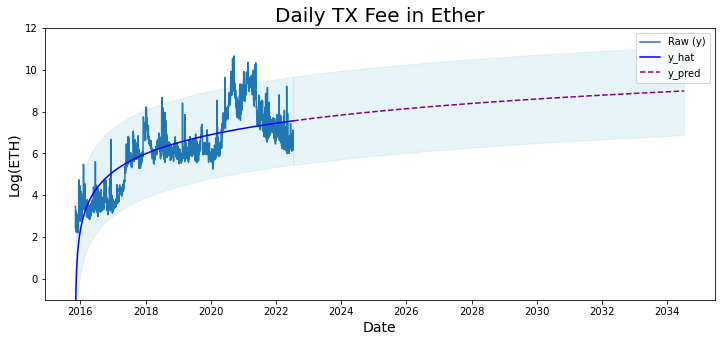

In [25]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2440,2440+N))

fig = plt.figure(figsize=(12,5))
ax = fig.gca()
plt.plot(dates, y, label="Raw (y)")
plt.plot(dates, y_hat, color='blue', label="y_hat")
plt.fill_between(dates, y_hat_lwr, y_hat_upr, alpha=0.3, color='lightblue')

plt.plot(dates_pred, y_pred, color='purple', linestyle='dashed', label="y_pred")
plt.fill_between(dates_pred, y_pred_lwr, y_pred_upr, alpha=0.3, color='lightblue')
plt.title("Daily TX Fee in Ether", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Log(ETH)", fontsize=14)
plt.ylim(-1,12)
plt.legend();
fig.savefig('../img/eth_daily_tx_fee.png')

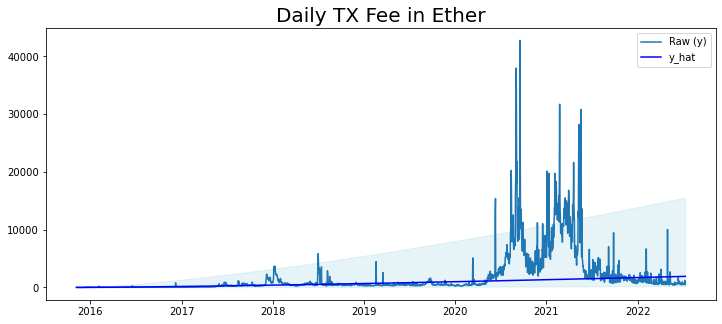

In [26]:
x = np.array(range(1,len(y)+1))
x_pred = np.array(range(2061,2061+N))

fig = plt.figure(figsize=(12,5))
plt.plot(dates, np.exp(y), label="Raw (y)")
plt.plot(dates, np.exp(y_hat), color='blue', label="y_hat")
plt.fill_between(dates, np.exp(y_hat_lwr), np.exp(y_hat_upr), alpha=0.3, color='lightblue')

plt.title("Daily TX Fee in Ether", fontsize=20)
fig.savefig('../img/eth_daily_tx_fee2.png')
plt.legend();

In [27]:
dates_ = np.append(dates, dates_pred[1:])
y_hat_ = np.append(y_hat, y_pred[1:])
y_hat_lwr_ = np.append(y_hat_lwr, y_pred_lwr[1:])
y_pred_upr_ = np.append(y_hat_upr, y_pred_upr[1:])

est_df = pd.DataFrame({'dates':dates_,
                        'pred':np.cumsum(np.exp(y_hat_)),
                        'pred_lwr':np.cumsum(np.exp(y_hat_lwr_)),
                        'pred_upr':np.cumsum(np.exp(y_pred_upr_))})

est_df = est_df.iloc[0:len(nevm_df)]

Text(0.5, 24.0, 'Date')

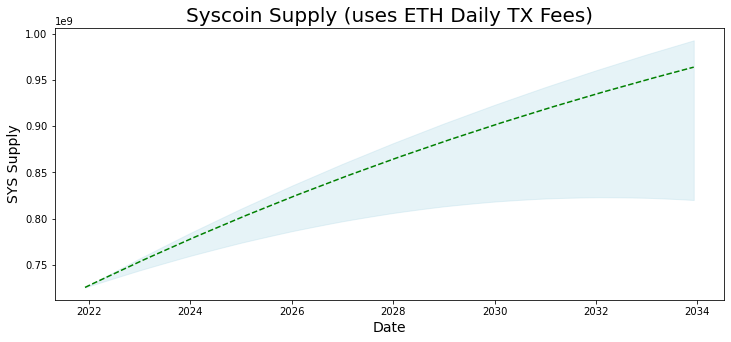

In [28]:
addition_supply = 100000000

coin_supply_upr = addition_supply + nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = addition_supply + nevm_df['supply_lwr'].values - est_df['pred_upr'].values

sys_dates = nevm_med['dates'].values
sys_supply =  addition_supply+nevm_med['supply'].values

fig = plt.figure(figsize=(12,5))
plt.plot(sys_dates, sys_supply, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply_proj.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

Text(0.5, 24.0, 'Date')

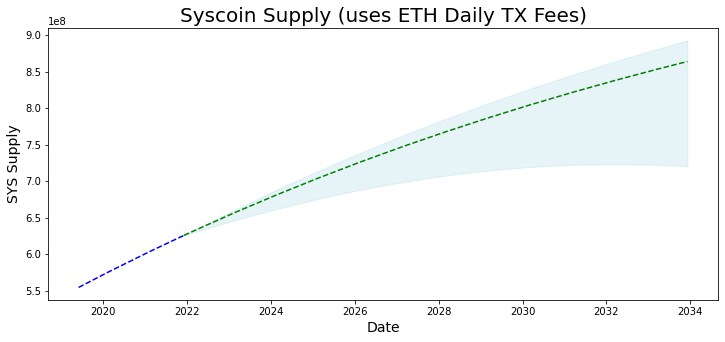

In [29]:
coin_supply_upr = nevm_df['supply_upr'].values - est_df['pred_lwr'].values
coin_supply_lwr = nevm_df['supply_lwr'].values - est_df['pred_upr'].values

fig = plt.figure(figsize=(12,5))
plt.plot(nevm_med['dates'].values, nevm_med['supply'].values, color='green', linestyle='dashed', label="y_pred")
plt.plot(pre_nevm['dates'].values, pre_nevm['supply'].values, color='blue', linestyle='dashed', label="y_pred")
plt.fill_between(nevm_med['dates'].values, coin_supply_lwr, coin_supply_upr, alpha=0.3, color='lightblue')
plt.title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=20)
fig.savefig('../img/syscoin_daily_supply_proj2.png')
plt.ylabel("SYS Supply", fontsize=14)
plt.xlabel("Date", fontsize=14)

In [30]:
pred_df = pd.DataFrame({'dates': nevm_med['dates'].values,
                        'pred':addition_supply + nevm_med['supply'].values,
                        'pred_lwr':addition_supply + coin_supply_lwr,
                        'pred_upr':addition_supply + coin_supply_upr})

In [31]:
mo = pd.to_datetime(pred_df['dates'].values).month
da = pd.to_datetime(pred_df['dates'].values).day

indices = []
m = 0
for k in range(0,len(pred_df)):
    if((mo[k] == 1) & (da[k] == 1)): indices.append(k)
    
pred_df.iloc[indices]

,dates,pred,pred_lwr,pred_upr
26,2022-01-01,7.274923e+08,7.268338e+08,7.277442e+08
391,2023-01-01,7.532947e+08,7.439698e+08,7.567852e+08
756,2024-01-01,7.778070e+08,7.596725e+08,7.843653e+08
1122,2025-01-01,8.011575e+08,7.738445e+08,8.106263e+08
1487,2026-01-01,8.232798e+08,7.863225e+08,8.354917e+08
1852,2027-01-01,8.442961e+08,7.970827e+08,8.590972e+08
2217,2028-01-01,8.642615e+08,8.060737e+08,8.815038e+08
2583,2029-01-01,8.832806e+08,8.132267e+08,9.028284e+08
2948,2030-01-01,9.012994e+08,8.184266e+08,9.230100e+08
3313,2031-01-01,9.184172e+08,8.217214e+08,9.421585e+08


### Price simulations

In [32]:
N = 5*365 + 27
LWR_SYS_PRICE = 0.25
UPR_SYS_PRICE = 25

price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
for k in range(1,50):
    sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE).reshape(-1,1)
    price_sim = np.hstack((price_sim,sim))

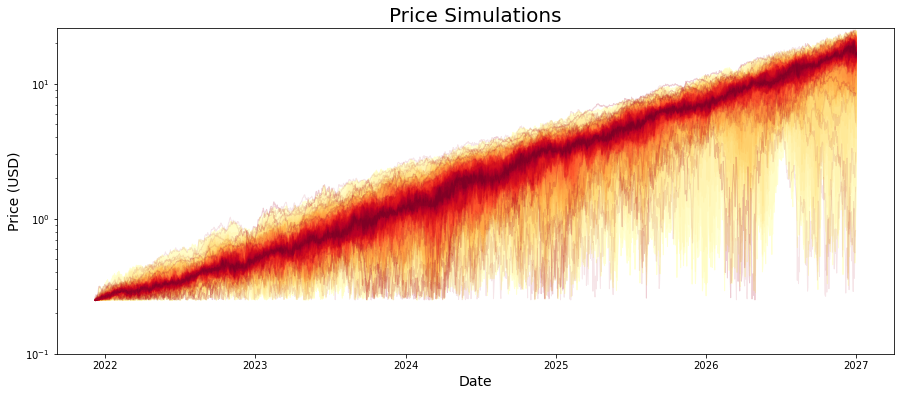

In [33]:
start = datetime.datetime(2021, 12, 6, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(15, 6))
ax = fig.gca()
plot_gp_dist(ax, price_sim.transpose(), date_times, palette="YlOrRd")
ax.set_ylabel("Price (USD)", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.set_yscale('log')
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_title("Price Simulations", fontsize=20)
ax.set_ylim((0.1,26))
fig.savefig('../img/price_simulations.png')

### Rewards simulations

In [34]:
nevm_df_final = copy.copy(nevm_df)
nevm_df_final = nevm_df_final.assign(supply=100000000+nevm_med['supply'].values)
nevm_df_final = nevm_df_final.assign(supply_lwr=100000000+coin_supply_lwr)
nevm_df_final = nevm_df_final.assign(supply_upr=100000000+coin_supply_upr)
nevm_df_final = nevm_df_final.assign(m_nodes = n_masternodes(100000000+nevm_med['supply'].values, share = MASTERNODE_SUPPLY_SHARE))
nevm_df_final = nevm_df_final.assign(daily_rewards_mu = nevm_med['daily_rewards'].values)
nevm_df_final = nevm_df_final.assign(blk_reward=nevm_med['blk_reward'].values)
nevm_df_final = nevm_df_final.assign(nevm_rewards=nevm_med['nevm_rewards'].values)
nevm_df_final = nevm_df_final.assign(pow_rewards=nevm_med['pow_rewards'].values)
nevm_df_final = nevm_df_final.assign(daily_rewards=nevm_med['daily_rewards'].values)
nevm_df_final = nevm_df_final[nevm_df_final['yr'].values > 2022]
nevm_df_final = nevm_df_final[nevm_df_final['yr'].values < 2028]

In [35]:
pred_dates = nevm_df_final['dates'].values
daily_rewards_lwr = nevm_df_final['daily_rewards_lwr'].values
daily_rewards_mu = nevm_df_final['daily_rewards_mu'].values
daily_rewards_upr = nevm_df_final['daily_rewards_lwr'].values

In [36]:
N = len(nevm_df_final)
price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
prices_sim = price_sim.reshape(-1,1)
reward_sim = price_sim*daily_rewards_mu[0:N]
reward_sim = reward_sim.reshape(-1,1)
for k in range(1,50):
    price_sim = gen_prices(N, LWR_SYS_PRICE, UPR_SYS_PRICE)
    prices_sim = np.hstack((prices_sim,price_sim.reshape(-1,1)))
    sim_med = price_sim*daily_rewards_mu[0:N]  
    sim_med = sim_med.reshape(-1,1)
    reward_sim = np.hstack((reward_sim,sim_med))

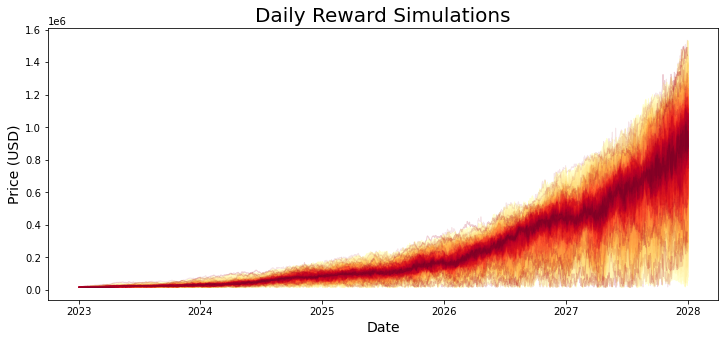

In [37]:
start = datetime.datetime(2023, 1, 1, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, reward_sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Reward Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

In [38]:
reward_mu = [np.quantile(reward_sim[0], 0.5)]
reward_lwr = [np.quantile(reward_sim[0], 0.05)]
reward_upr = [np.quantile(reward_sim[0], 0.95)]

price_mu = [np.quantile(prices_sim[0], 0.5)]
price_lwr = [np.quantile(prices_sim[0], 0.05)]
price_upr = [np.quantile(prices_sim[0], 0.95)]

for day in range(1,N):
    reward_mu.append(np.quantile(reward_sim[day], 0.5))
    reward_lwr.append(np.quantile(reward_sim[day], 0.05))
    reward_upr.append(np.quantile(reward_sim[day], 0.95))
    
    price_mu.append(np.quantile(prices_sim[day], 0.5))
    price_lwr.append(np.quantile(prices_sim[day], 0.05))
    price_upr.append(np.quantile(prices_sim[day], 0.95))    

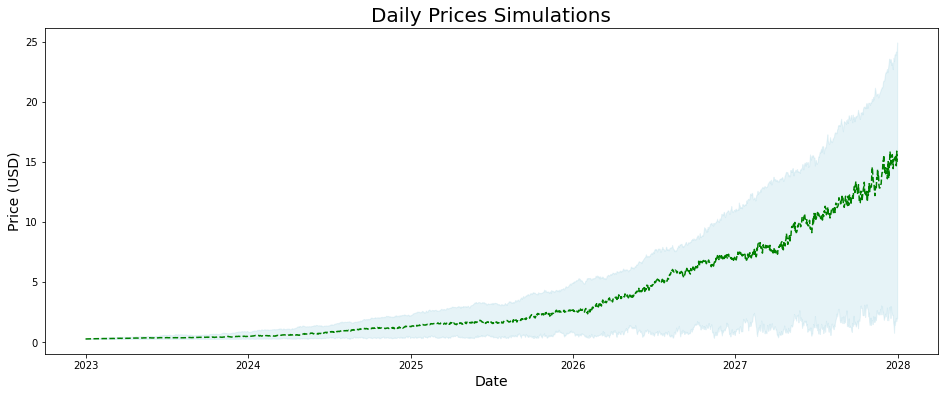

In [39]:
fig = plt.figure(figsize=(16, 6))
ax = fig.gca()
plt.plot(date_times, price_mu, color='green', linestyle='dashed', label="y_pred")
plt.fill_between(date_times, price_lwr, price_upr, alpha=0.3, color='lightblue')
plt.ylabel("Price (USD)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Daily Prices Simulations", fontsize=20)
fig.savefig('../img/reward_simulations.png')

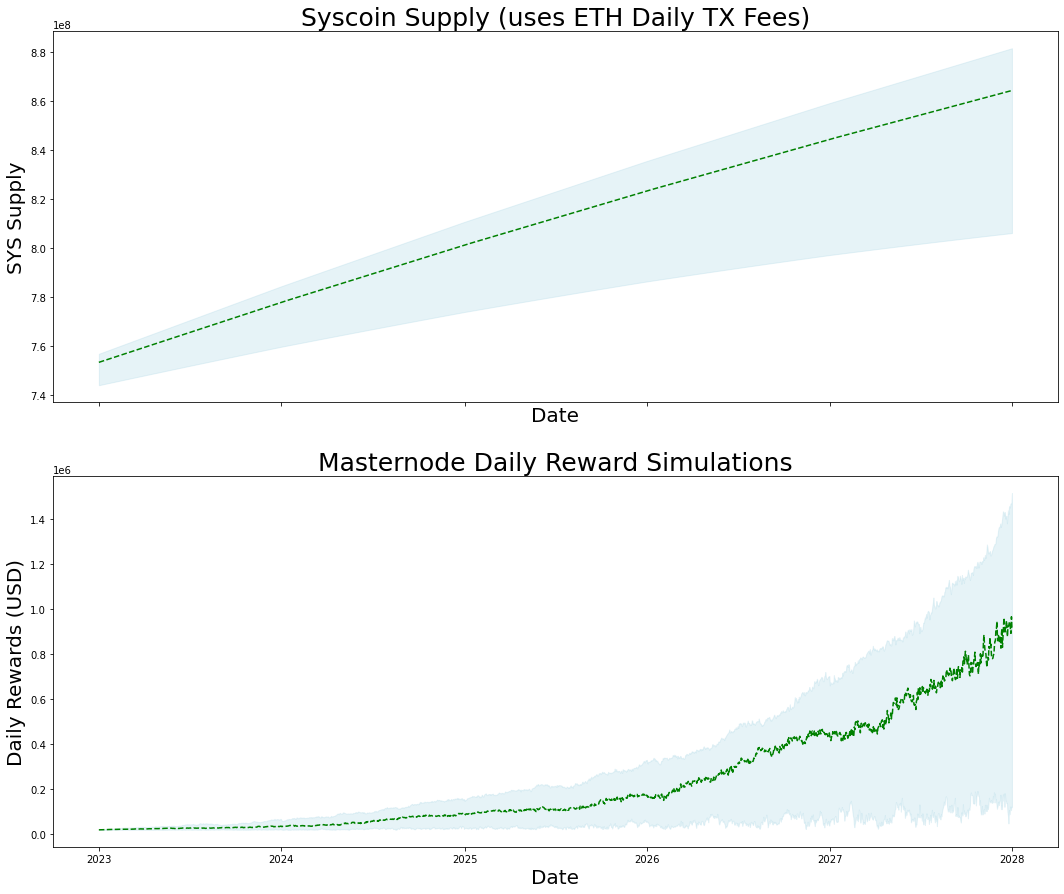

In [40]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

sys_supply =  nevm_df_final['supply'].values 
sys_supply_lwr =  nevm_df_final['supply_lwr'].values 
sys_supply_upr =  nevm_df_final['supply_upr'].values 

s_ax.plot(date_times, sys_supply, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, sys_supply_lwr, sys_supply_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Syscoin Supply (uses ETH Daily TX Fees)", fontsize=25)
s_ax.set_ylabel("SYS Supply", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

r_ax.fill_between(date_times, reward_lwr, reward_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, reward_mu, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Daily Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Daily Reward Simulations", fontsize=25)
fig.savefig('../img/supply_mn_reward_simulations.png')


In [41]:
dat = {
    'date' : date_times,
    'year' : [date_times[k].year for k in range(N)],
    'month' : [date_times[k].month for k in range(N)],    
    'nsys' : sys_supply,
    'nsys_lwr' : sys_supply_lwr,
    'nsys_upr' : sys_supply_upr,
    'price' : price_mu,
    'price_lwr' : price_lwr,
    'price_upr' : price_upr,    
    'reward' : reward_mu,
    'reward_lwr' : reward_lwr,
    'reward_upr' : reward_upr,
    'num_m_nodes' : nevm_df_final['m_nodes'].values[0:N]
}
  
proj = pd.DataFrame(dat)
proj = proj.set_index('date')

In [42]:
proj_system_aggr = pd.DataFrame(proj.groupby([(proj.index.year), (proj.index.month)])['nsys'].median())
proj_system_aggr['nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_lwr'].median().values
proj_system_aggr['nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['nsys_upr'].median().values
proj_system_aggr['reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward'].sum().values
proj_system_aggr['reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_lwr'].sum().values
proj_system_aggr['reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['reward_upr'].sum().values
proj_system_aggr['price'] = proj.groupby([(proj.index.year), (proj.index.month)])['price'].median().values
proj_system_aggr['price_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_lwr'].median().values
proj_system_aggr['price_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_upr'].median().values
proj_system_aggr['num_m_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['num_m_nodes'].max().values

In [43]:
proj_system_aggr.index.names = ['year','month']
proj_system_aggr.reset_index(level=['year', 'month'], inplace=True)
proj_system_aggr.to_csv('../resources/proj_system_aggr.csv')

### Investment nodes

In [44]:
N_INVEST_MASTERNODES = 400

nevm_df_invest = copy.copy(nevm_df_final[['dates','yr','mo','da']])
nevm_df_invest = nevm_df_invest.assign(blk_invest=nevm_df_final['blk_reward_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(pow_invest_lwr=nevm_df_final['pow_rewards_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(pow_invest_upr=nevm_df_final['pow_rewards_upr'].values)
nevm_df_invest = nevm_df_invest.assign(nevm_invest_lwr=nevm_df_final['nevm_rewards_lwr'].values)
nevm_df_invest = nevm_df_invest.assign(nevm_invest_upr=nevm_df_final['nevm_rewards_upr'].values)
nevm_df_invest = nevm_df_invest.assign(num_m_nodes = nevm_df_final['m_nodes'].values + N_INVEST_MASTERNODES)
nevm_df_invest = nevm_df_invest.assign(blk_share = 1/nevm_df_invest['num_m_nodes'].values)

In [45]:
invest_eth_burn = copy.copy(est_df[391:(391+len(nevm_df_final))])

#### Adjust for masternode allocation

In [46]:
nevm_df_invest.loc[:, 'blk_invest'] = 0.9*0.75*nevm_df_invest.loc[:, 'blk_invest']

#### Adjust for senority

In [47]:
blk_invest = copy.copy(nevm_df_invest.loc[:, 'blk_invest'])

seg = nevm_df_invest['yr'] > 2023
nevm_df_invest.loc[seg, 'blk_invest'] = 1.35*blk_invest[seg]

seg = np.array(range(0,len(nevm_df_invest))) > 911
nevm_df_invest.loc[seg, 'blk_invest'] = 2*blk_invest[seg]


In [48]:
nevm_df_invest.tail(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share
2212,2027-12-27,2027,12,27,86.150472,5.27,10.55,10.55,10.55,3337.568284,0.0003
2213,2027-12-28,2027,12,28,86.150472,5.27,10.55,10.55,10.55,3337.754289,0.0003
2214,2027-12-29,2027,12,29,86.150472,5.27,10.55,10.55,10.55,3337.940294,0.0003
2215,2027-12-30,2027,12,30,86.150472,5.27,10.55,10.55,10.55,3338.126298,0.0003
2216,2027-12-31,2027,12,31,86.150472,5.27,10.55,10.55,10.55,3338.312303,0.0003


In [49]:
investment_share = N_INVEST_MASTERNODES*nevm_df_invest['blk_share'].values

invest_supply_lwr = nevm_df_invest['blk_invest'].values + nevm_df_invest['pow_invest_lwr'].values + nevm_df_invest['nevm_invest_lwr'].values
invest_supply_upr = nevm_df_invest['blk_invest'].values + nevm_df_invest['pow_invest_upr'].values + nevm_df_invest['nevm_invest_upr'].values
invest_supply_lwr = NUM_DAILY_BLOCKS*investment_share*invest_supply_lwr
invest_supply_upr = NUM_DAILY_BLOCKS*investment_share*invest_supply_upr

invest_supply_med = (invest_supply_lwr + invest_supply_upr)/2

nevm_df_invest = nevm_df_invest.assign(invest_supply_med = invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(invest_supply_lwr = invest_supply_lwr)
nevm_df_invest = nevm_df_invest.assign(invest_supply_upr = invest_supply_upr)

nevm_df_invest.head(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share,invest_supply_med,invest_supply_lwr,invest_supply_upr
391,2023-01-01,2023,1,1,52.88509,5.27,10.55,10.55,10.55,2961.201912,0.000338,5551.093504,5345.685019,5756.501990
392,2023-01-02,2023,1,2,52.88509,5.27,10.55,10.55,10.55,2961.430277,0.000338,5550.665442,5345.272796,5756.058088
393,2023-01-03,2023,1,3,52.88509,5.27,10.55,10.55,10.55,2961.658642,0.000338,5550.237446,5344.860638,5755.614255
394,2023-01-04,2023,1,4,52.88509,5.27,10.55,10.55,10.55,2961.887007,0.000338,5549.809516,5344.448543,5755.170490
395,2023-01-05,2023,1,5,52.88509,5.27,10.55,10.55,10.55,2962.115372,0.000338,5549.381652,5344.036511,5754.726794


In [50]:
nevm_df_invest.tail(5)

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,blk_share,invest_supply_med,invest_supply_lwr,invest_supply_upr
2212,2027-12-27,2027,12,27,86.150472,5.27,10.55,10.55,10.55,3337.568284,0.0003,7221.501043,7039.255783,7403.746303
2213,2027-12-28,2027,12,28,86.150472,5.27,10.55,10.55,10.55,3337.754289,0.0003,7221.098607,7038.863503,7403.333711
2214,2027-12-29,2027,12,29,86.150472,5.27,10.55,10.55,10.55,3337.940294,0.0003,7220.696216,7038.471266,7402.921165
2215,2027-12-30,2027,12,30,86.150472,5.27,10.55,10.55,10.55,3338.126298,0.0003,7220.293869,7038.079074,7402.508664
2216,2027-12-31,2027,12,31,86.150472,5.27,10.55,10.55,10.55,3338.312303,0.0003,7219.891567,7037.686925,7402.096210


In [51]:
nevm_df_invest = nevm_df_invest.assign(price = price_mu)
nevm_df_invest = nevm_df_invest.assign(price_lwr = price_lwr)
nevm_df_invest = nevm_df_invest.assign(price_upr = price_upr)

nevm_df_invest = nevm_df_invest.assign(rewards = price_mu*invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(rewards_lwr = price_lwr*invest_supply_med)
nevm_df_invest = nevm_df_invest.assign(rewards_upr = price_upr*invest_supply_med)

### Back of the Envelope DAOSYS

In [52]:
cwd =  os.getcwd().replace("sys_notebooks/notebooks","/daosys")
os.chdir(cwd)
from python.dev.math.interest import Yield

apy = 0.08
delta_t = 3600*24

mn_yield_mu =  nevm_df_invest['invest_supply_med'].values 
mn_yield_lwr =  nevm_df_invest['invest_supply_lwr'].values 
mn_yield_upr =  nevm_df_invest['invest_supply_upr'].values 

cum_mn_yield_mu =  np.cumsum(mn_yield_mu) 
cum_mn_yield_lwr =  np.cumsum(mn_yield_lwr) 
cum_mn_yield_upr =  np.cumsum(mn_yield_upr) 

daosys_yield_mu = Yield().apply(cum_mn_yield_mu, delta_t, apy)
daosys_yield_lwr = Yield().apply(cum_mn_yield_lwr, delta_t, apy)
daosys_yield_upr = Yield().apply(cum_mn_yield_upr, delta_t, apy)

nevm_df_invest = nevm_df_invest.assign(daosys_yield_mu = daosys_yield_mu)
nevm_df_invest = nevm_df_invest.assign(daosys_yield_lwr = daosys_yield_lwr)
nevm_df_invest = nevm_df_invest.assign(daosys_yield_upr = daosys_yield_upr)

nevm_df_invest = nevm_df_invest.assign(daosys_rewards = price_mu*daosys_yield_mu)
nevm_df_invest = nevm_df_invest.assign(daosys_rewards_lwr = price_lwr*daosys_yield_lwr)
nevm_df_invest = nevm_df_invest.assign(daosys_rewards_upr = price_upr*daosys_yield_upr)

nevm_df_invest = nevm_df_invest.assign(tot_yield_mu = daosys_yield_mu + mn_yield_mu)
nevm_df_invest = nevm_df_invest.assign(tot_yield_lwr = daosys_yield_lwr + mn_yield_lwr)
nevm_df_invest = nevm_df_invest.assign(tot_yield_upr = daosys_yield_upr + mn_yield_upr)

mn_rewards =  nevm_df_invest['rewards'].values 
mn_rewards_lwr =  nevm_df_invest['rewards_lwr'].values 
mn_rewards_upr =  nevm_df_invest['rewards_upr'].values 

daosys_rewards =  nevm_df_invest['daosys_rewards'].values 
daosys_rewards_lwr =  nevm_df_invest['daosys_rewards_lwr'].values 
daosys_rewards_upr =  nevm_df_invest['daosys_rewards_upr'].values 

nevm_df_invest = nevm_df_invest.assign(tot_rewards = mn_rewards + daosys_rewards)
nevm_df_invest = nevm_df_invest.assign(tot_rewards_lwr = mn_rewards_lwr + daosys_rewards_lwr)
nevm_df_invest = nevm_df_invest.assign(tot_rewards_upr = mn_rewards_upr + daosys_rewards_upr)

cwd =  os.getcwd().replace("/daosys","/sys_notebooks/notebooks")
os.chdir(cwd)


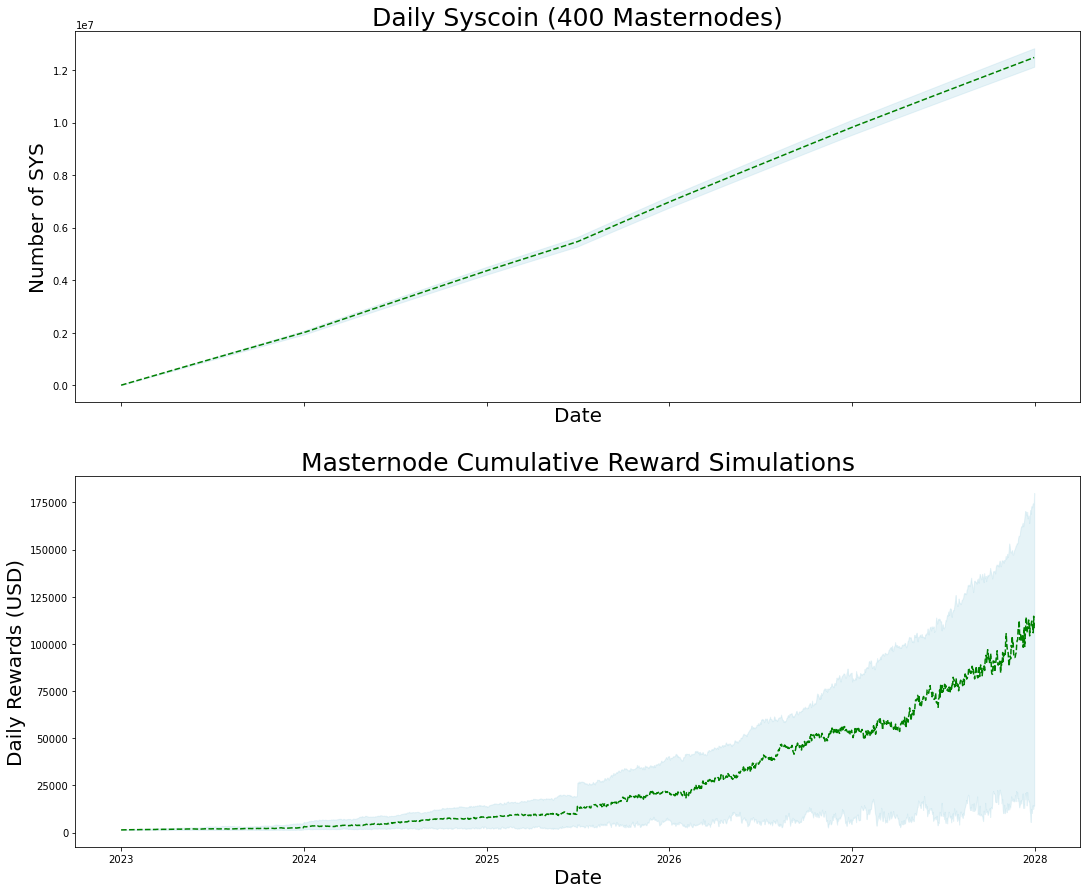

In [53]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

sys_supply =  nevm_df_invest['invest_supply_med'].values 
sys_supply_lwr =  nevm_df_invest['invest_supply_lwr'].values 
sys_supply_upr =  nevm_df_invest['invest_supply_upr'].values 

sys_supply = np.cumsum(sys_supply)
sys_supply_lwr = np.cumsum(sys_supply_lwr)
sys_supply_upr = np.cumsum(sys_supply_upr)

s_ax.plot(date_times, sys_supply, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, sys_supply_lwr, sys_supply_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Daily Syscoin (400 Masternodes)", fontsize=25)
s_ax.set_ylabel("Number of SYS", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

reward_mu =  nevm_df_invest['rewards'].values 
reward_lwr =  nevm_df_invest['rewards_lwr'].values 
reward_upr =  nevm_df_invest['rewards_upr'].values 

r_ax.fill_between(date_times, reward_lwr, reward_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, reward_mu, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Daily Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Cumulative Reward Simulations", fontsize=25)
fig.savefig('../img/supply_mn_reward_output.png')

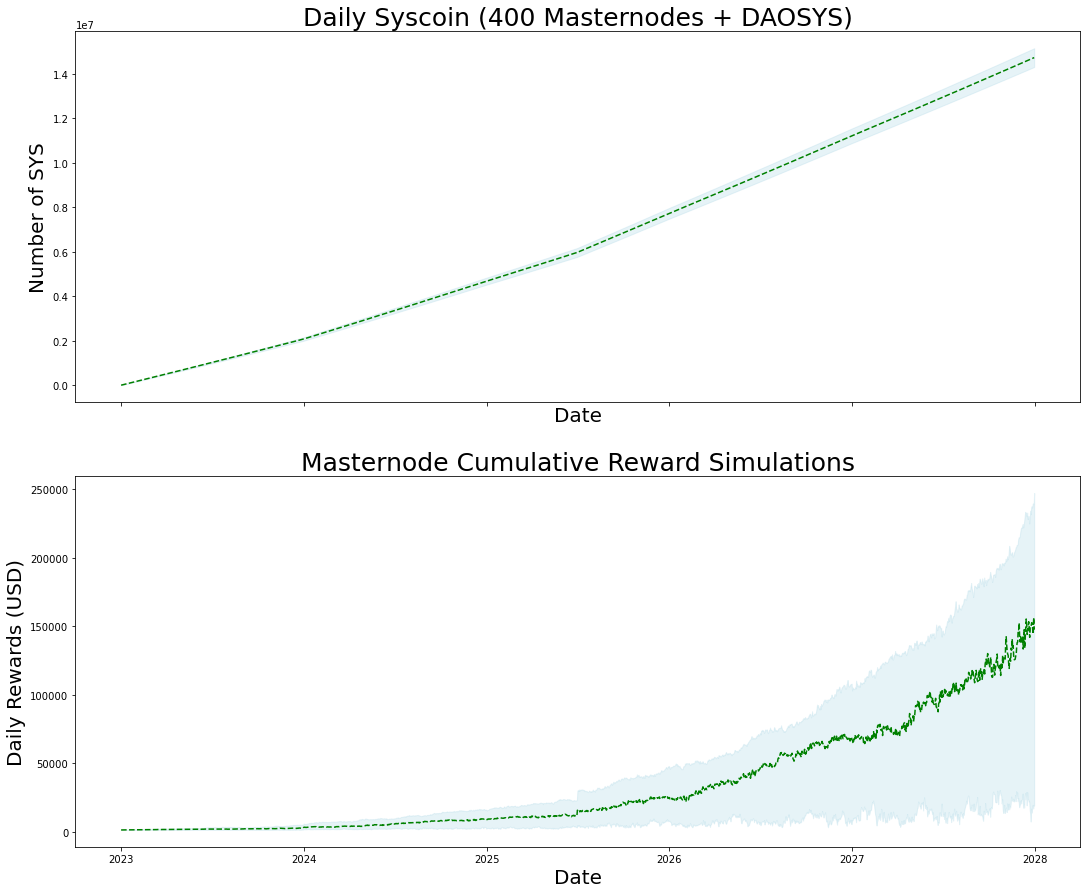

In [54]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

tot_sys_mu =  nevm_df_invest['tot_yield_mu'].values 
tot_sys_lwr =  nevm_df_invest['tot_yield_lwr'].values 
tot_sys_upr =  nevm_df_invest['tot_yield_upr'].values 

tot_sys_mu = np.cumsum(tot_sys_mu)
tot_sys_lwr = np.cumsum(tot_sys_lwr)
tot_sys_upr = np.cumsum(tot_sys_upr)

s_ax.plot(date_times, tot_sys_mu, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, tot_sys_lwr, tot_sys_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Daily Syscoin (400 Masternodes + DAOSYS)", fontsize=25)
s_ax.set_ylabel("Number of SYS", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

tot_rewards =  nevm_df_invest['tot_rewards'].values 
tot_rewards_lwr =  nevm_df_invest['tot_rewards_lwr'].values 
tot_rewards_upr =  nevm_df_invest['tot_rewards_upr'].values 

r_ax.fill_between(date_times, tot_rewards_lwr, tot_rewards_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, tot_rewards, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Daily Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Cumulative Reward Simulations", fontsize=25)
fig.savefig('../img/supply_tot_reward_output.png')

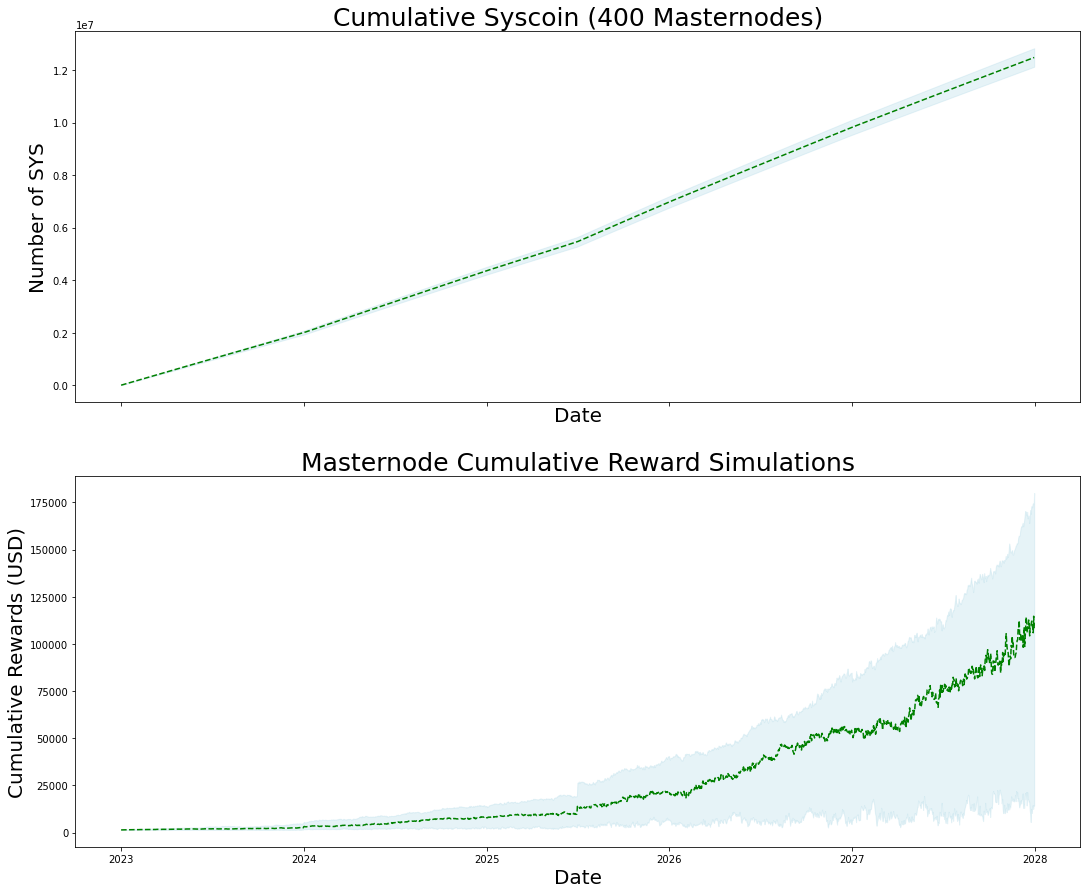

In [55]:
fig, (s_ax, r_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(18, 15))

sys_supply =  nevm_df_invest['invest_supply_med'].values 
sys_supply_lwr =  nevm_df_invest['invest_supply_lwr'].values 
sys_supply_upr =  nevm_df_invest['invest_supply_upr'].values 

sys_supply = np.cumsum(sys_supply)
sys_supply_lwr = np.cumsum(sys_supply_lwr)
sys_supply_upr = np.cumsum(sys_supply_upr)

s_ax.plot(date_times, sys_supply, color='green', linestyle='dashed', label="y_pred")
s_ax.fill_between(date_times, sys_supply_lwr, sys_supply_upr, alpha=0.3, color='lightblue')
s_ax.set_title("Cumulative Syscoin (400 Masternodes)", fontsize=25)
s_ax.set_ylabel("Number of SYS", fontsize=20)
s_ax.set_xlabel("Date", fontsize=20)

reward_mu =  nevm_df_invest['rewards'].values 
reward_lwr =  nevm_df_invest['rewards_lwr'].values 
reward_upr =  nevm_df_invest['rewards_upr'].values 

r_ax.fill_between(date_times, reward_lwr, reward_upr, alpha=0.3, color='lightblue')
r_ax.plot(date_times, reward_mu, color='green', linestyle='dashed', label="y_pred")
r_ax.set_ylabel("Cumulative Rewards (USD)", fontsize=20)
r_ax.set_xlabel("Date", fontsize=20)
r_ax.set_title("Masternode Cumulative Reward Simulations", fontsize=25)
fig.savefig('../img/supply_mn_reward_output.png')

In [56]:
dat = {
    'date' : nevm_df_invest['dates'].values,
    'year' : nevm_df_invest['yr'].values,
    'month' : nevm_df_invest['mo'].values,  
    
    'mn_nsys' : nevm_df_invest['invest_supply_med'].values,
    'mn_nsys_lwr' : nevm_df_invest['invest_supply_lwr'].values,
    'mn_nsys_upr' : nevm_df_invest['invest_supply_upr'].values,
    
    'daosys_nsys' : nevm_df_invest['daosys_yield_mu'].values,
    'daosys_nsys_lwr' : nevm_df_invest['daosys_yield_lwr'].values,
    'daosys_nsys_upr' : nevm_df_invest['daosys_yield_upr'].values,    
    
    'tot_nsys' : nevm_df_invest['tot_yield_mu'].values,
    'tot_nsys_lwr' : nevm_df_invest['tot_yield_lwr'].values,
    'tot_nsys_upr' : nevm_df_invest['tot_yield_upr'].values,  
    
    'price' : nevm_df_invest['price'].values,
    'price_lwr' : nevm_df_invest['price_lwr'].values,
    'price_upr' : nevm_df_invest['price_upr'].values,   
    
    'mn_reward' : nevm_df_invest['rewards'].values,
    'mn_reward_lwr' : nevm_df_invest['rewards_lwr'].values,
    'mn_reward_upr' : nevm_df_invest['rewards_upr'].values,

    'daosys_reward' : nevm_df_invest['daosys_rewards'].values,
    'daosys_reward_lwr' : nevm_df_invest['daosys_rewards_lwr'].values,
    'daosys_reward_upr' : nevm_df_invest['daosys_rewards_upr'].values,
    
    'tot_reward' : nevm_df_invest['tot_rewards'].values,
    'tot_reward_lwr' : nevm_df_invest['tot_rewards_lwr'].values,
    'tot_reward_upr' : nevm_df_invest['tot_rewards_upr'].values,     
    
    'tot_nodes' : nevm_df_invest['num_m_nodes'].values,
    'investment_nodes' : N_INVEST_MASTERNODES
}
  
proj = pd.DataFrame(dat)
proj = proj.set_index('date')
proj.to_csv('../resources/daosys_proj.csv')

In [73]:
nevm_df_invest

,dates,yr,mo,da,blk_invest,pow_invest_lwr,pow_invest_upr,nevm_invest_lwr,nevm_invest_upr,num_m_nodes,...,daosys_yield_upr,daosys_rewards,daosys_rewards_lwr,daosys_rewards_upr,tot_yield_mu,tot_yield_lwr,tot_yield_upr,tot_rewards,tot_rewards_lwr,tot_rewards_upr
391,2023-01-01,2023,1,1,52.885090,5.27,10.55,10.55,10.55,2961.201912,...,1.213068,0.292446,0.281624,0.303267,5552.263286,5346.811515,5757.715058,1388.065822,1388.055000,1388.076643
392,2023-01-02,2023,1,2,52.885090,5.27,10.55,10.55,10.55,2961.430277,...,2.426042,0.590943,0.563745,0.626487,5553.004916,5347.525702,5758.484130,1402.668637,1389.508061,1433.997830
393,2023-01-03,2023,1,3,52.885090,5.27,10.55,10.55,10.55,2961.658642,...,3.638923,0.889378,0.845059,0.954018,5553.746522,5348.239866,5759.253178,1407.601306,1388.817622,1456.062529
394,2023-01-04,2023,1,4,52.885090,5.27,10.55,10.55,10.55,2961.887007,...,4.851711,1.184011,1.128671,1.255975,5554.488104,5348.954007,5760.022201,1405.675206,1391.419717,1437.949859
395,2023-01-05,2023,1,5,52.885090,5.27,10.55,10.55,10.55,2962.115372,...,6.064404,1.488006,1.414419,1.606502,5555.229661,5349.668125,5760.791198,1413.508819,1395.180102,1471.675104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,2027-12-27,2027,12,27,86.150472,5.27,10.55,10.55,10.55,3337.568284,...,2697.088510,40535.761371,4679.976414,64360.432308,9844.528073,9588.221333,10100.834814,152135.466482,17938.866696,236686.600801
2213,2027-12-28,2027,12,28,86.150472,5.27,10.55,10.55,10.55,3337.754289,...,2698.648615,39389.842934,5135.015731,65159.393192,9845.647339,9589.312352,10101.982326,147765.784456,19673.811501,239514.216851
2214,2027-12-29,2027,12,29,86.150472,5.27,10.55,10.55,10.55,3337.940294,...,2700.208633,38512.589922,4438.334851,65275.342572,9846.766565,9590.403333,10103.129798,144407.587099,16996.611021,239829.787482
2215,2027-12-30,2027,12,30,86.150472,5.27,10.55,10.55,10.55,3338.126298,...,2701.768564,41726.378544,5087.727589,65292.918370,9847.885752,9591.494275,10104.277228,156385.248188,19474.298287,239783.829421


In [57]:
proj_invest_aggr = pd.DataFrame(proj.groupby([(proj.index.year), (proj.index.month)])['mn_nsys'].sum())
proj_invest_aggr['mn_nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['mn_nsys_lwr'].sum().values
proj_invest_aggr['mn_nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['mn_nsys_upr'].sum().values

proj_invest_aggr['daosys_nsys'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_nsys'].sum().values
proj_invest_aggr['daosys_nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_nsys_lwr'].sum().values
proj_invest_aggr['daosys_nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_nsys_upr'].sum().values

proj_invest_aggr['tot_nsys'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_nsys'].sum().values
proj_invest_aggr['tot_nsys_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_nsys_lwr'].sum().values
proj_invest_aggr['tot_nsys_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_nsys_upr'].sum().values

proj_invest_aggr['mn_reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['mn_reward'].sum().values
proj_invest_aggr['mn_reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['mn_reward_lwr'].sum().values
proj_invest_aggr['mn_reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['mn_reward_upr'].sum().values

proj_invest_aggr['daosys_reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_reward'].sum().values
proj_invest_aggr['daosys_reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_reward_lwr'].sum().values
proj_invest_aggr['daosys_reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['daosys_reward_upr'].sum().values

proj_invest_aggr['tot_reward'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_reward'].sum().values
proj_invest_aggr['tot_reward_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_reward_lwr'].sum().values
proj_invest_aggr['tot_reward_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_reward_upr'].sum().values

proj_invest_aggr['price'] = proj.groupby([(proj.index.year), (proj.index.month)])['price'].median().values
proj_invest_aggr['price_lwr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_lwr'].median().values
proj_invest_aggr['price_upr'] = proj.groupby([(proj.index.year), (proj.index.month)])['price_upr'].median().values
proj_invest_aggr['total_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['tot_nodes'].max().values
proj_invest_aggr['investment_nodes'] = proj.groupby([(proj.index.year), (proj.index.month)])['investment_nodes'].max().values

In [58]:
proj_invest_aggr.index.names = ['year','month']
proj_invest_aggr.reset_index(level=['year', 'month'], inplace=True)
proj_invest_aggr.to_csv('../resources/proj_invest_aggr.csv')

In [72]:
proj_invest_aggr

,year,month,mn_nsys,mn_nsys_lwr,mn_nsys_upr,daosys_nsys,daosys_nsys_lwr,daosys_nsys_upr,tot_nsys,tot_nsys_lwr,...,daosys_reward_lwr,daosys_reward_upr,tot_reward,tot_reward_lwr,tot_reward_upr,price,price_lwr,price_upr,total_nodes,investment_nodes
0,2023,1,171885.146073,165524.837514,178245.454633,579.765050,558.311861,601.218240,172464.911124,166083.149374,...,140.695924,1.846994e+02,4.559673e+04,43371.435786,5.091544e+04,0.263250,0.251179,0.304242,2968.052863,400
1,2023,2,154899.095781,149167.326240,160630.865322,1487.669373,1432.620775,1542.717971,156386.765154,150599.947016,...,367.099935,5.684959e+02,4.425839e+04,40020.634888,5.716546e+04,0.283221,0.255899,0.366070,2974.447084,400
2,2023,3,171107.501855,164775.968657,177439.035054,2711.902090,2611.552907,2812.251274,173819.403946,167387.521563,...,667.648949,1.147223e+03,5.205917e+04,44401.374315,7.060258e+04,0.300585,0.255874,0.400683,2981.526400,400
3,2023,4,165201.529124,159088.536095,171314.522153,3687.422402,3550.975799,3823.869005,168888.951526,162639.511894,...,915.276347,1.672449e+03,5.350228e+04,43479.972512,7.371130e+04,0.316629,0.257186,0.439780,2988.377350,400
4,2023,5,170310.860652,164008.805765,176612.915539,4906.196976,4724.651756,5087.742196,175217.057628,168733.457521,...,1228.624118,2.436385e+03,5.987480e+04,45476.454087,8.389778e+04,0.342801,0.259795,0.477115,2995.456666,400
5,2023,6,164434.171288,158349.572990,170518.769585,5805.990375,5591.149878,6020.830873,170240.161663,163940.722868,...,1478.074342,3.205246e+03,5.923180e+04,44940.240576,9.037633e+04,0.349053,0.264252,0.532747,3002.307617,400
6,2023,7,169521.603069,163248.753276,175794.452863,7090.299756,6827.935641,7352.663871,176611.902825,170076.688917,...,1798.340200,4.418424e+03,6.294334e+04,46437.937263,1.061358e+05,0.356700,0.264677,0.591987,3009.386933,400
7,2023,8,169123.301768,162865.190416,175381.413120,8196.377952,7893.085352,8499.670552,177319.679720,170758.275768,...,2093.752746,5.159841e+03,6.350144e+04,46943.184462,1.079734e+05,0.357342,0.265091,0.616328,3016.466248,400
8,2023,9,163290.234379,157247.965462,169332.503297,8982.667504,8650.279637,9315.055370,172272.901883,165898.245099,...,2328.919546,5.452036e+03,6.682741e+04,46320.331916,1.009010e+05,0.387415,0.267534,0.584698,3023.317199,400
9,2023,10,168344.987478,162115.676282,174574.298674,10365.286868,9981.737595,10748.836141,178710.274346,172097.413877,...,2600.247374,7.100881e+03,7.146710e+04,46458.689111,1.182155e+05,0.399007,0.259404,0.666907,3030.396515,400


In [59]:
mo = proj_invest_aggr['month'].values

indices = []
m = 0
for k in range(0,len(proj_invest_aggr)):
    if(mo[k] == 12): indices.append(k)

proj_invest_aggr[['year','month','price','price_lwr','price_upr','total_nodes','investment_nodes']].iloc[indices]  


,year,month,price,price_lwr,price_upr,total_nodes,investment_nodes
11,2023,12,0.456288,0.270497,0.870394,3044.326781,400
23,2024,12,1.240553,0.401329,2.218530,3123.729300,400
35,2025,12,2.578649,0.773897,4.565175,3198.955594,400
47,2026,12,7.020403,0.913613,10.827542,3270.420573,400
59,2027,12,15.003435,2.103514,23.255279,3338.312303,400


In [60]:
proj_invest_aggr[['year','month','mn_nsys','mn_nsys_lwr','mn_nsys_upr',
                  'daosys_nsys','daosys_nsys_lwr','daosys_nsys_upr',
                  'tot_nsys','tot_nsys_lwr','tot_nsys_upr']].iloc[indices]    

,year,month,mn_nsys,mn_nsys_lwr,mn_nsys_upr,daosys_nsys,daosys_nsys_lwr,daosys_nsys_upr,tot_nsys,tot_nsys_lwr,tot_nsys_upr
11,2023,12,167573.804061,161373.029155,173774.578966,12524.237607,12060.800146,12987.675068,180098.041668,173433.829301,186762.254034
23,2024,12,197496.571856,191453.920435,203539.223278,27842.349013,26906.842637,28777.855390,225338.920870,218360.763071,232317.078668
35,2025,12,254593.192702,248693.085041,260493.300363,44768.923220,43374.189323,46163.657117,299362.115922,292067.274364,306656.957479
47,2026,12,238579.735064,232808.951366,244350.518762,63356.455835,61512.940648,65199.971022,301936.190899,294321.892014,309550.489784
59,2027,12,224003.910671,218350.840663,229656.980679,80794.658525,78511.854893,83077.462157,304798.569196,296862.695555,312734.442836


In [61]:
proj_invest_aggr[['year','month','mn_reward','mn_reward_lwr','mn_reward_upr',
                  'daosys_reward','daosys_reward_lwr','daosys_reward_upr',
                  'tot_reward','tot_reward_lwr','tot_reward_upr']].iloc[indices]

,year,month,mn_reward,mn_reward_lwr,mn_reward_upr,daosys_reward,daosys_reward_lwr,daosys_reward_upr,tot_reward,tot_reward_lwr,tot_reward_upr
11,2023,12,7.669436e+04,45680.329198,1.446462e+05,5.733367e+03,3289.392230,1.122102e+04,8.242773e+04,48969.721429,1.558673e+05
23,2024,12,2.427306e+05,80209.820841,4.380205e+05,3.423843e+04,10935.914909,6.383395e+04,2.769690e+05,91145.735750,5.018544e+05
35,2025,12,6.553545e+05,192249.784289,1.165616e+06,1.152538e+05,32764.096525,2.114530e+05,7.706083e+05,225013.880814,1.377069e+06
47,2026,12,1.676752e+06,222512.669199,2.577765e+06,4.452621e+05,57328.489619,7.045274e+05,2.122014e+06,279841.158818,3.282292e+06
59,2027,12,3.324297e+06,474767.607879,5.191350e+06,1.199170e+06,166320.322365,1.925662e+06,4.523468e+06,641087.930244,7.117013e+06


### Sanity Check: Back of the Envelope Breakdown

In [62]:
total_invest_sys = 400*100000
total_invest_sys

40000000

In [63]:
y0 = 576*(78.35 + 5.27 + 10.55)
y1 = 576*(100.48 + 5.27 + 10.55)  # 78.35*0.95*1.15
y2 = 576*(95.45 + 5.27 + 10.55) # 100.48*0.95
y2_5 = 576*(141.42 + 5.27 + 10.55) # 78.35*0.95*0.95*2
y3 = 576*(134.34 + 5.27 + 10.55) # 141.42*0.95
y4 = 576*(127.63 + 5.27 + 10.55) # 127.63*0.95
y4

82627.20000000001

In [64]:
ty1 = y0*365
ty2 = ty1 + y1*365
ty3 = ty2 + (y2*365/2 +  y2_5*365/2) 
ty4 = ty3 + y3*365
ty5 = ty4 + y4*365
ty5

134203550.4

In [65]:
MN_SHARE = 0.75*0.9
y0 = 576*(78.35*MN_SHARE + 5.27 + 10.55)
y1 = 576*(100.48*MN_SHARE + 5.27 + 10.55)  # 78.35*0.95*1.15
y2 = 576*(95.45*MN_SHARE + 5.27 + 10.55) # 100.48*0.95
y2_5 = 576*(141.42*MN_SHARE + 5.27 + 10.55) # 78.35*0.95*0.95*2
y3 = 576*(134.34*MN_SHARE + 5.27 + 10.55) # 141.42*0.95
y4 = 576*(127.63*MN_SHARE + 5.27 + 10.55) # 127.63*0.95
y4

58734.863999999994

In [66]:
ty1 = y0*365
ty2 = ty1 + y1*365
ty3 = ty2 + (y2*365/2 +  y2_5*365/2) 
ty4 = ty3 + y3*365
ty5 = ty4 + y4*365
ty5

95992141.32

In [67]:
shares = 400/nevm_df_invest['num_m_nodes'].values

MN_SHARE = 0.75*0.9
y0 = shares[0]*576*(78.35*MN_SHARE + 5.27 + 10.55)
y1 = shares[365]*576*(100.48*MN_SHARE + 5.27 + 10.55)  # 78.35*0.95*1.15
y2 = shares[2*365]*576*(95.45*MN_SHARE + 5.27 + 10.55) # 100.48*0.95
y2_5 = shares[3*365]*576*(141.42*MN_SHARE + 5.27 + 10.55) # 78.35*0.95*0.95*2
y3 = shares[4*365]*576*(134.34*MN_SHARE + 5.27 + 10.55) # 141.42*0.95
y4 = shares[5*365]*576*(127.63*MN_SHARE + 5.27 + 10.55) # 127.63*0.95
y4

7037.671573927257

In [68]:
ty1 = y0*365
ty2 = ty1 + y1*365
ty3 = ty2 + (y2*365/2 +  y2_5*365/2) 
ty4 = ty3 + y3*365
ty5 = ty4 + y4*365

print('Return after 5 years is {:2f} %'.format(100*ty5/total_invest_sys))

Return after 5 years is 30.279488 %
